In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Fetch Dataset 

In [2]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split
from pyscf.scf import hf

data_path = "../../dataset/EthenT/"
postfix = "EthenT"
dim = 72
N_ELECTRONS = 16
basis = "6-311++g**"
#data_path = "../../../cc2ai/ethen/"
#postfix = "_ethen_6-31g**"
#dim = 48
#N_ELECTRONS = 16
#basis = "6-31g**"
#data_path = "../../dataset/TSmall_sto3g"
#postfix = "TSmall_sto3g"
#dim = 26
#N_ELECTRONS = 30
#basis = "sto-3g"
#data_path = "../../../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

#S, P = np.load(join(data_path, "dataset" + postfix + ".npy"))
S = np.load(join(data_path, "S" + postfix + ".npy")).reshape(-1, dim, dim)
P = np.load(join(data_path, "P" + postfix + ".npy")).reshape(-1, dim, dim)

#index = np.load(join(data_path, "index" + postfix + ".npy"))


ind = int(0.8 * len(S))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))[ind:]
#molecules = (molecules[:ind], molecules[ind:])
s_test = S[ind:].reshape(-1, dim, dim)
p_test = P[ind:].reshape(-1, dim, dim)


#H = [hf.get_hcore(mol.get_pyscf_molecule()) for mol in molecules]


# Energies 

## Calculate ENergies 

In [3]:
from SCFInitialGuess.utilities.analysis import measure_hf_energy

energies = measure_hf_energy(p_test, molecules)

## See distribution 

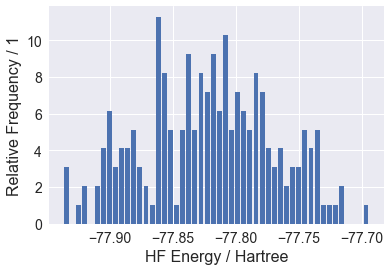

In [4]:
n_bins = 50
#offset = np.min(E)
hist, edges = np.histogram(energies, bins=n_bins, density=True)

centers = (edges[:-1] + edges[1:]) / 2
width = np.mean(np.diff(centers)) * 0.8
plt.bar(centers, hist, width=width)

plt.ylabel("Relative Frequency / 1")
plt.xlabel("HF Energy / Hartree")

#plt.savefig(figure_save_path + "EnergyDistributionDataset.pdf")

plt.show()

# Distances 

## Calculate 

In [13]:
import scipy.spatial as sp

def distance_sum(mol):
    m = sp.distance_matrix(mol.positions, mol.positions)
    return np.sum(m.flatten())
    
distances = []
for mol in molecules:
    distances.append(distance_sum(mol))
#np.array(distances)

## Distribution 

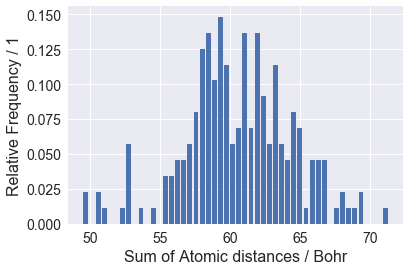

In [6]:
n_bins = 50
#offset = np.min(E)
hist, edges = np.histogram(distances, bins=n_bins, density=True)

centers = (edges[:-1] + edges[1:]) / 2
width = np.mean(np.diff(centers)) * 0.8
plt.bar(centers, hist, width=width)

plt.ylabel("Relative Frequency / 1")
plt.xlabel("Sum of Atomic distances / Bohr")

#plt.savefig(figure_save_path + "EnergyDistributionDataset.pdf")

plt.show()

# Iterations 

In [8]:
fpath = "../../dataset/EthenT/EmbeddedBlocks/"

#f_conv = np.load(fpath + "f_conv.npy")

f_gwh = np.load(fpath + "f_gwh.npy")
f_embedded_gwh = np.load(fpath + "f_embedded_gwh.npy")
f_sad = np.load(fpath + "f_sad.npy")
f_embedded_sad = np.load(fpath + "f_embedded_sad.npy")

In [10]:
from SCFInitialGuess.utilities.dataset import density_from_fock_batch

g_gwh = density_from_fock_batch(f_gwh, s_test, molecules)
g_embedded_gwh = density_from_fock_batch(f_embedded_gwh, s_test, molecules)
g_sad = density_from_fock_batch(f_sad, s_test, molecules)
g_embedded_sad = density_from_fock_batch(f_embedded_sad, s_test, molecules)

In [12]:
from SCFInitialGuess.utilities.analysis import measure_iterations, mf_initializer
from SCFInitialGuess.utilities.usermessages import Messenger as msg

msg.print_level = 0

it_gwh = measure_iterations(mf_initializer, g_gwh, molecules)
it_embedded_gwh = measure_iterations(mf_initializer, g_embedded_gwh, molecules)
it_sad = measure_iterations(mf_initializer, g_sad, molecules)
it_embedded_sad = measure_iterations(mf_initializer, g_embedded_sad, molecules)

## Vs. Energies 

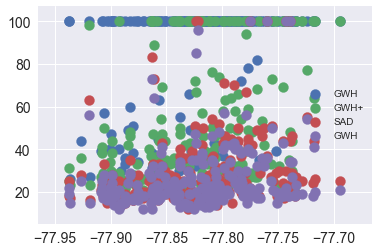

In [15]:
plt.scatter(energies, it_gwh, label="GWH")
plt.scatter(energies, it_embedded_gwh, label="GWH+")
plt.scatter(energies, it_sad, label="SAD")
plt.scatter(energies, it_embedded_sad, label="GWH")

plt.legend()
plt.show()

## Vs Distances 

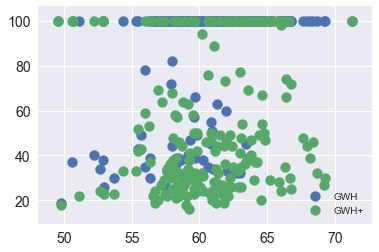

In [18]:
plt.scatter(distances, it_gwh, label="GWH")
plt.scatter(distances, it_embedded_gwh, label="GWH+")
#plt.scatter(distances, it_sad, label="SAD")
#plt.scatter(distances, it_embedded_sad, label="GWH")

plt.legend()
plt.show()